In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob as glob

In [2]:
def consolidate(fileformat):
    files = np.array(glob.glob(fileformat))
    numbers=[int(f.split("/")[-1].split(".")[0]) for f in files]
    files=files[np.argsort(numbers)]

    tensors=[]
    print(f"Loading {len(files)} files from {fileformat}")
    for fname in files:
        with open(fname,'rb') as f:
            tensors.append(np.load(f))
    
    return np.vstack(tensors)

def loaddata(loaddir):
    msk=consolidate(loaddir+'attn/*.npy')
    etens=consolidate(loaddir+'entropy_t/*.npy')
    ctens=consolidate(loaddir+'codelength_t/*.npy') 
    ttens=consolidate(loaddir+'tok/*.npy')

    return {'e': etens,
            'c': ctens,
            'm': msk,
            't': ttens,
            'dir': loaddir}

def takeaverage(data):

    nos=data['m'].sum(axis=0)
    weights=data['m']/data['m'].sum(axis=0,keepdims=True)
    eaverage=(data['e']*weights).sum(axis=0)
    caverage=(data['c']*weights[:,:-1]).sum(axis=0)

    return {'e': eaverage,
            'c': caverage,
            'n': nos}

def loaddataC(loaddir, is_olmo=False):
    msk=consolidate(loaddir+'attn/*.npy')
    if is_olmo:
        etens=consolidate(loaddir+'entropy/*.npy')
        ctens=consolidate(loaddir+'codelength/*.npy')
    else:
        etens=consolidate(loaddir+'entropy_c/*.npy')
        ctens=consolidate(loaddir+'codelength_c/*.npy') 
    ptens=consolidate(loaddir+'pleak/*.npy')
    ltens=consolidate(loaddir+'tlens/*.npy')
    ttens=consolidate(loaddir+'tok/*.npy')

    return {'e': etens,
            'c': ctens,
            'm': msk,
            'p': ptens,
            'l': ltens,
            't': ttens,
            'dir': loaddir}

def takeaverageC(data):
    positions=data['l'].cumsum(axis=-1)
    pflat = positions.flatten()
    msk = data['m'].flatten()
    gmask=np.ones_like(data['m'])
    gmask[:,-1]=0
    gmask=gmask.astype('bool').flatten()
    validpos, inv = np.unique(pflat, return_inverse=True)
    nsamples = np.bincount(inv, weights=msk)
    e_sum = np.bincount(inv, weights=data['e'].flatten() * msk)
    eaverage = np.divide(e_sum, nsamples, out=np.zeros_like(e_sum), where=nsamples>0)
    c_sum = np.bincount(inv[gmask], weights=data['c'].flatten() * msk[gmask],minlength=nsamples.shape[0])
    caverage = np.divide(c_sum, nsamples, out=np.zeros_like(c_sum), where=nsamples>0)
    
    averages={"n": nsamples,
              'c': caverage,
              'e': eaverage,
              'vp': validpos}
    return averages

In [ ]:
keys = ["simple", "wiki", "BBC", 'c4','BooksumText','BooksumAnalysis', "BookChapter", "gpc", "poetry"]
models = ['olmo', 'oss', 'dclm']
data = {k:{} for k in models}
load = {k:{} for k in models}

parentoss='/scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/oss/'
parentolmo='/scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/olmo/'
parentdclm='/scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files_dclm/data/'

In [4]:
# data and load will hold keys for each model: dclm, olmo, oss and the vals are dicts for each model consisting of the keys defined above (dataset names)
# so: dict of dicts of arrays

for model, parent in zip(['oss','olmo','dclm'], [parentoss, parentolmo, parentdclm]):
    for k in keys:
        loaddir = parent+f"{k}/"
        load[f"{model}"][k] = loaddataC(parent+k+"/", is_olmo=(model=='olmo'))

Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/oss/simple/attn/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/oss/simple/entropy_c/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/oss/simple/codelength_c/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/oss/simple/pleak/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/oss/simple/tlens/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/oss/simple/tok/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/oss/wiki/attn/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/oss/wiki/entropy_c/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/oss/wiki/codelength_c/*.npy
Loading 2000 files from /scratch/g

In [5]:
load

{'olmo': {'simple': {'e': array([[2.0990469e+00, 6.1250623e-02, 5.3944722e-02, ..., 3.6235843e-02,
           9.2772543e-01, 1.1384454e-01],
          [4.6539869e+00, 5.3920937e+00, 5.0728264e+00, ..., 7.4946396e-03,
           1.2857077e-01, 7.6520597e-03],
          [2.7438228e+00, 5.9042301e-02, 6.7795599e-01, ..., 1.3624902e+00,
           3.5452303e-03, 2.6864348e-02],
          ...,
          [3.5094378e+00, 2.5090318e+00, 4.1433368e+00, ..., 4.6539555e+00,
           4.6589975e+00, 4.6595345e+00],
          [3.2695694e+00, 4.0288126e-01, 2.8176993e-01, ..., 2.4698687e+00,
           2.7600212e+00, 3.2156768e+00],
          [3.5817089e+00, 3.7706369e-01, 1.5074554e-01, ..., 4.3922606e+00,
           4.3929186e+00, 4.3927431e+00]], shape=(2000, 2000), dtype=float32),
   'c': array([[5.9809202e-01, 6.6406331e-03, 5.4850518e-03, ..., 1.9598754e-04,
           4.8532491e-03, 2.4615266e+00],
          [1.1713525e+01, 7.7812996e+00, 4.6367168e+00, ..., 4.1488180e-04,
           7.01945

In [6]:
for model, parent in zip(['oss','olmo','dclm'], [parentoss, parentolmo, parentdclm]):
    temp_data = {}
    for k in keys:
        print(f"Processing {model} {k}")
        temp_data[k] = takeaverageC(load[f'{model}'][k])

    data[f"{model}"] = temp_data    
data

Processing oss simple
Processing oss wiki
Processing oss BBC
Processing oss c4
Processing oss BooksumText
Processing oss BooksumAnalysis
Processing oss BookChapter
Processing oss gpc
Processing oss poetry
Processing olmo simple
Processing olmo wiki
Processing olmo BBC
Processing olmo c4
Processing olmo BooksumText
Processing olmo BooksumAnalysis
Processing olmo BookChapter
Processing olmo gpc
Processing olmo poetry
Processing dclm simple
Processing dclm wiki
Processing dclm BBC
Processing dclm c4
Processing dclm BooksumText
Processing dclm BooksumAnalysis
Processing dclm BookChapter
Processing dclm gpc
Processing dclm poetry


{'olmo': {'simple': {'n': array([543., 545., 518., ...,   1.,   1.,   1.], shape=(10673,)),
   'c': array([2.8761742 , 2.25577511, 1.94955942, ..., 0.04954004, 0.32415363,
          0.        ], shape=(10673,)),
   'e': array([3.57919214, 2.97931747, 2.43182156, ..., 0.24233995, 0.84594703,
          0.08688818], shape=(10673,)),
   'vp': array([    1,     2,     3, ..., 11164, 11172, 11182], shape=(10673,))},
  'wiki': {'n': array([542., 526., 516., ...,   1.,   1.,   1.], shape=(11653,)),
   'c': array([3.00212120e+00, 2.51025533e+00, 2.00943563e+00, ...,
          3.10720119e-04, 1.34323692e+00, 0.00000000e+00], shape=(11653,)),
   'e': array([3.73783056e+00, 3.06609564e+00, 2.42005663e+00, ...,
          3.25149251e-03, 1.17511678e+00, 3.84622097e+00], shape=(11653,)),
   'vp': array([    1,     2,     3, ..., 11907, 11916, 11919], shape=(11653,))},
  'BBC': {'n': array([515., 478., 500., ...,   1.,   1.,   1.], shape=(10270,)),
   'c': array([2.95972418e+00, 2.61245762e+00, 2.0752

In [7]:
chars_per_token = {m:{} for m in models}
for model in ['oss','olmo','dclm']:
    for k in keys:
        lengths = load[model][k]['l']
        mask = load[model][k]['m']
        total_chars = (lengths * mask).sum()
        total_tokens = mask.sum()
        chars_per_token[model][k] = float(total_chars / total_tokens)

chars_per_token

{'olmo': {'simple': 4.441004842113976,
  'wiki': 4.614810615162802,
  'BBC': 4.7315087575072505,
  'c4': 4.79068525,
  'BooksumText': 4.480418759942165,
  'BooksumAnalysis': 4.704050606818006,
  'BookChapter': 4.033749,
  'gpc': 3.92512275,
  'poetry': 4.1616833940087306},
 'oss': {'simple': 4.482810247140165,
  'wiki': 4.656039043844452,
  'BBC': 4.7714981224598265,
  'c4': 4.83516025,
  'BooksumText': 4.545819077372218,
  'BooksumAnalysis': 4.743884484654654,
  'BookChapter': 4.073905,
  'gpc': 3.982517,
  'poetry': 4.185185827176238},
 'dclm': {'simple': 4.3204427602712405,
  'wiki': 4.538547475966953,
  'BBC': 4.545924761351403,
  'c4': 4.652658579289644,
  'BooksumText': 4.413099487071395,
  'BooksumAnalysis': 4.634995208857594,
  'BookChapter': 3.7930947973986995,
  'gpc': 3.59260180090045,
  'poetry': 3.7493240733445146}}

In [8]:
descriptions = {
"simple" : "Simple\nEnglish\nWikipedia",
"wiki" : "English\nWikipedia",
"BBC" : "BBC\nNews\nArticles",
"c4": "C4\nInternet\nCorpus",
"BooksumText": "CliffNotes\nChapter\nSummaries",
"BooksumAnalysis": "CliffNotes\nChapter\nAnalyses",
"BookChapter": "CliffNotes\nBook\nChapters",
"gpc": "Gutenberg\nPoetry\nCollection",
"poetry": "Poetry\nFoundation\nPoems",
}

/tmp/ipykernel_2746639/2581858748.py:84: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim([0.0,2.0e4])


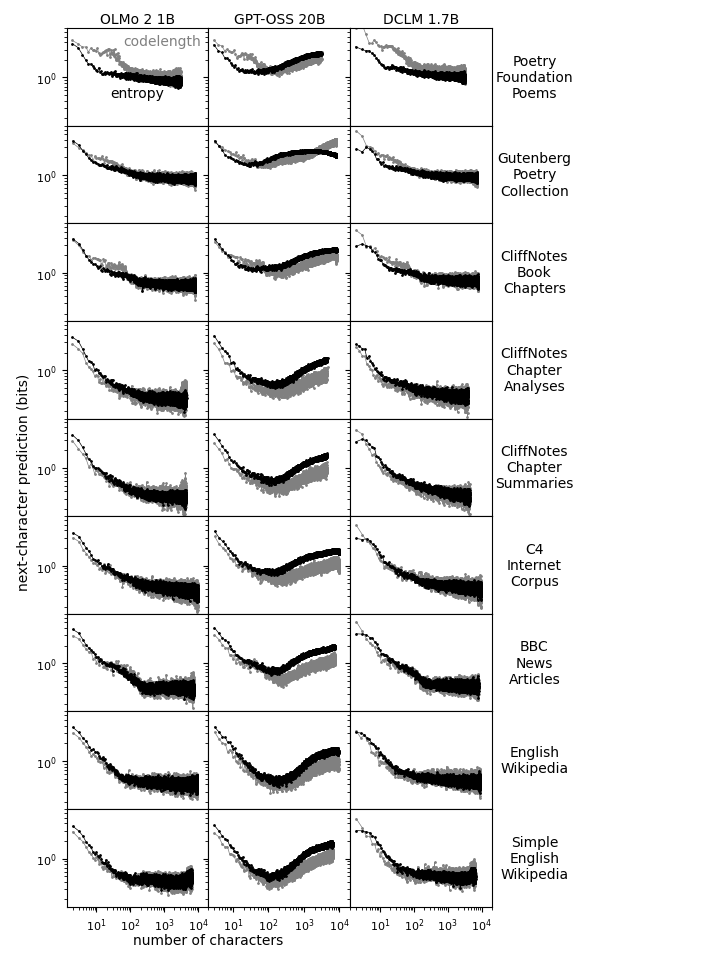

In [19]:
figh=24/2.54
figw=18/2.54

fig2=plt.figure(figsize=(figw,figh))
axfalse=fig2.add_subplot([0,0,1,1])
axfalse.set_xticks([])
axfalse.set_yticks([])
axfalse.patch.set_visible(False)
axfalse.axis('off')

nrows=len(keys)
ncols=3

bbuff=0.05
tbuff=0.02
lbuff=0.08
awidth=0.2
aheight=(1-bbuff-tbuff)/nrows

axes=[]
for j in np.arange(nrows):
    axrow=[]
    for i in np.arange(ncols):
        coordinates=[lbuff+i*awidth,1-tbuff-(j+1)*aheight,awidth,aheight]

        axrow.append(fig2.add_subplot(coordinates))
    axes.append(axrow)
axes=np.array(axes)

fs=10
ts=8
lw=0.5
ms=1


for ax, k in zip(axes[:,0],keys[::-1]):
    v=data['olmo'][k]
    
    msk=v['n']>200
    ax.plot(v['vp'][msk][:]+1,v['e'][msk][:],marker='o',ms=ms, lw=lw,label='entropy', c='k')
    ax.plot(v['vp'][msk][:]+1,v['c'][msk][:],marker='o',ms=ms,lw=lw,label='codelength', c='gray',zorder=-1)

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.tick_params(axis='both', which='major', labelsize=ts)
    ax.tick_params(axis='both', which='minor', labelsize=ts)

for ax, k in zip(axes[:,1],keys[::-1]):
    v=data['oss'][k]

    msk=v['n']>200
    ax.plot(v['vp'][msk][1:]+1,v['e'][msk][1:],marker='o',ms=ms,lw=lw,label='entropy', c='k')
    ax.plot(v['vp'][msk][1:]+1,v['c'][msk][1:],marker='o',ms=ms,lw=lw,label='codelength', c='gray',zorder=-1)

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.tick_params(axis='both', which='major', labelsize=ts)
    ax.tick_params(axis='both', which='minor', labelsize=ts)
    ax.text(1.3,0.5,descriptions[k],va='center',ha='center',transform=ax.transAxes, fontsize=fs)
    ax.set_yticklabels([])

for ax, k in zip(axes[:, 2], keys[::-1]):
    v = data['dclm'][k]
    
    msk=v['n']>200
    ax.plot(v['vp'][msk][:]+1,v['e'][msk][:],marker='o',ms=ms, lw=lw,label='entropy', c='k')
    ax.plot(v['vp'][msk][:]+1,v['c'][msk][:],marker='o',ms=ms,lw=lw,label='codelength', c='gray',zorder=-1)

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.tick_params(axis='both', which='major', labelsize=ts)
    ax.tick_params(axis='both', which='minor', labelsize=ts)
    ax.text(1.3,0.5,descriptions[k],va='center',ha='center',transform=ax.transAxes, fontsize=fs)
    ax.set_yticklabels([])
    

for ax in axes[:-1,:].flatten():
    ax.set_xticklabels([])

for ax in axes[:,:].flatten():
    ax.set_xlim([0.0,2.0e4])
    ax.set_ylim([0.15,7.0])


axes[0,0].text(0.5,1.02,"OLMo 2 1B",va='bottom',ha='center',transform=axes[0,0].transAxes, fontsize=fs)
axes[0,1].text(0.5,1.02,"GPT-OSS 20B",va='bottom',ha='center',transform=axes[0,1].transAxes, fontsize=fs)
axes[0,2].text(0.5,1.02,"DCLM 1.7B",va='bottom',ha='center',transform=axes[0,2].transAxes, fontsize=fs)

axes[0,0].text(0.5,0.4, "entropy", ha='center', va='top', fontsize=fs,transform=axes[0,0].transAxes)
axes[0,0].text(0.95,0.94, "codelength", ha='right', va='top', fontsize=fs, color='gray',transform=axes[0,0].transAxes)

fig2.text(0.01, 0.5, 'next-character prediction (bits)', ha='left', va='center', fontsize=fs, rotation=90)
fig2.text(lbuff+awidth, 0.01, 'number of characters', ha='center', va='baseline', fontsize=fs)
# save as pdf
fig2.savefig('dclm_olmo_oss_comparison.pdf', bbox_inches='tight')

In [10]:
# do the same but for tokens
dataT = {k:{} for k in models}
loadT = {k:{} for k in models}

In [13]:
for model, parent in zip(['oss','dclm'], [parentoss, parentdclm]):
    temp_load = {}
    for k in keys:
        loaddir = parent+f"{k}/"
        temp_load[k] = loaddata(parent+k+"/")
        
    loadT[f"{model}"] = temp_load

Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/oss/simple/attn/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/oss/simple/entropy_t/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/oss/simple/codelength_t/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/oss/simple/tok/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/oss/wiki/attn/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/oss/wiki/entropy_t/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/oss/wiki/codelength_t/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/oss/wiki/tok/*.npy
Loading 2000 files from /scratch/gpfs/WBIALEK/ls1546/llms-entropy/colin_files/data/oss/BBC/attn/*.npy
Loading 2000 files from /scratch/gpfs/WBIA

In [14]:
for model, parent in zip(['oss','dclm'], [parentoss, parentdclm]):
    temp_data = {}
    for k in keys:
        print(f"Processing {model} {k}")
        temp_data[k] = takeaverage(loadT[f'{model}'][k])

    dataT[f"{model}"] = temp_data

Processing oss simple
Processing oss wiki
Processing oss BBC
Processing oss c4
Processing oss BooksumText
Processing oss BooksumAnalysis
Processing oss BookChapter


ValueError: operands could not be broadcast together with shapes (1998,2000) (2000,2000) 

In [ ]:
dataT

{'olmo': {},
 'oss': {'simple': {'e': array([3.44877954, 1.79545359, 1.23646678, ..., 1.90682068, 2.08886685,
          1.88998152], shape=(2000,)),
   'c': array([2.72236269, 1.27368611, 0.95575612, ..., 1.43993102, 1.43675929,
          1.63783877], shape=(1999,)),
   'n': array([2000, 2000, 2000, ...,  381,  381,  381], shape=(2000,))},
  'wiki': {'e': array([3.50668006, 1.98361484, 1.36353091, ..., 1.56868854, 1.63885707,
          1.66402204], shape=(2000,)),
   'c': array([2.72638751, 1.40779683, 1.05085303, ..., 1.13131277, 1.12219041,
          1.14181035], shape=(1999,)),
   'n': array([2000, 2000, 2000, ..., 1935, 1934, 1934], shape=(2000,))},
  'BBC': {'e': array([3.56030643, 1.96823025, 1.41334686, ..., 1.94518645, 1.94817555,
          1.80213567], shape=(2000,)),
   'c': array([2.82351365, 1.47158077, 1.17079379, ..., 1.25665024, 1.21869816,
          1.29873554], shape=(1999,)),
   'n': array([2000, 2000, 2000, ...,  271,  271,  270], shape=(2000,))},
  'c4': {'e': array

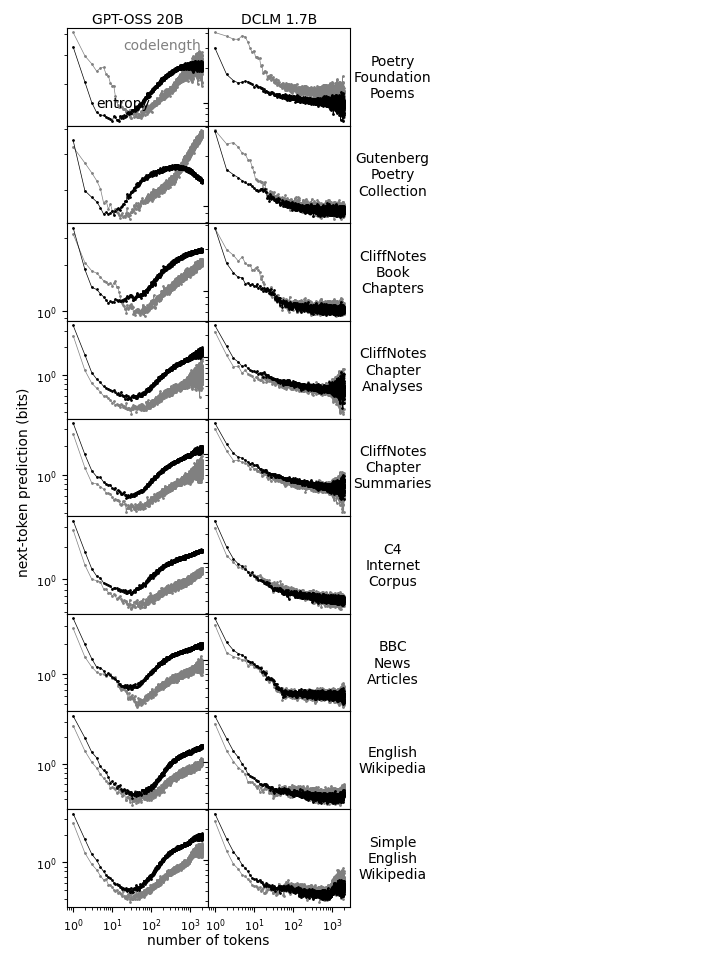

In [20]:
figh=24/2.54
figw=18/2.54

fig2=plt.figure(figsize=(figw,figh))
axfalse=fig2.add_subplot([0,0,1,1])
axfalse.set_xticks([])
axfalse.set_yticks([])
axfalse.patch.set_visible(False)
axfalse.axis('off')

nrows=len(keys)
ncols=2

bbuff=0.05
tbuff=0.02
lbuff=0.08
awidth=0.2
aheight=(1-bbuff-tbuff)/nrows

axes=[]
for j in np.arange(nrows):
    axrow=[]
    for i in np.arange(ncols):
        coordinates=[lbuff+i*awidth,1-tbuff-(j+1)*aheight,awidth,aheight]

        axrow.append(fig2.add_subplot(coordinates))
    axes.append(axrow)
axes=np.array(axes)

fs=10
ts=8
lw=0.5
ms=1


for ax, k in zip(axes[:,0],keys[::-1]):

    v=dataT['oss'][k]

    xvals=np.arange(len(v['e']))+1
    ax.plot(xvals,v['e'],marker='o',ms=ms, lw=lw,label='entropy', c='k')
    ax.plot(xvals[:-1],v['c'],marker='o',ms=ms,lw=lw,label='codelength', c='gray',zorder=-1)

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.tick_params(axis='both', which='major', labelsize=ts)
    ax.tick_params(axis='both', which='minor', labelsize=ts)


for ax, k in zip(axes[:, 1], keys[::-1]):
    v = dataT['dclm'][k]
    
    xvals=np.arange(len(v['e']))+1
    ax.plot(xvals,v['e'],marker='o',ms=ms, lw=lw,label='entropy', c='k')
    ax.plot(xvals[:-1],v['c'],marker='o',ms=ms,lw=lw,label='codelength', c='gray',zorder=-1)

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.tick_params(axis='both', which='major', labelsize=ts)
    ax.tick_params(axis='both', which='minor', labelsize=ts)
    ax.text(1.3,0.5,descriptions[k],va='center',ha='center',transform=ax.transAxes, fontsize=fs)

    ax.tick_params(which='major',labelleft=False)

for ax in axes[:-1,:].flatten():
    ax.set_xticklabels([])

for ax in axes[:,:].flatten():
    # ax.set_xlim([0.0,3e3])
    # ax.set_ylim([2.2,15.0])
    ax.tick_params(which='minor',labelleft=False)

axes[0,0].text(0.5,1.02,"GPT-OSS 20B",va='bottom',ha='center',transform=axes[0,0].transAxes, fontsize=fs)
axes[0,1].text(0.5,1.02,"DCLM 1.7B",va='bottom',ha='center',transform=axes[0,1].transAxes, fontsize=fs)

axes[0,0].text(0.4,0.3, "entropy", ha='center', va='top', fontsize=fs,transform=axes[0,0].transAxes)
axes[0,0].text(0.95,0.9, "codelength", ha='right', va='top', fontsize=fs, color='gray',transform=axes[0,0].transAxes)

fig2.text(0.01, 0.5, 'next-token prediction (bits)', ha='left', va='center', fontsize=fs, rotation=90)
fig2.text(lbuff+awidth, 0.01, 'number of tokens', ha='center', va='baseline', fontsize=fs)
# save as pdf
fig2.savefig('dclm_oss_token_comparison.pdf', bbox_inches='tight')

NameError: name 'dataT' is not defined

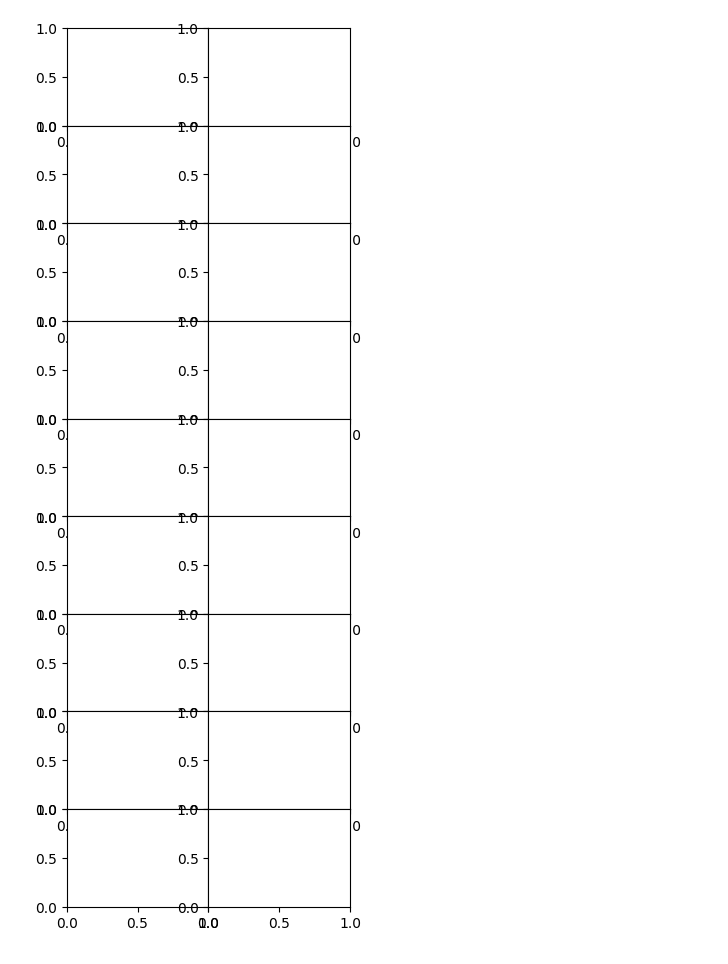

In [9]:
figh=24/2.54
figw=18/2.54

fig3=plt.figure(figsize=(figw,figh))
axfalse=fig3.add_subplot([0,0,1,1])
axfalse.set_xticks([])
axfalse.set_yticks([])
axfalse.patch.set_visible(False)
axfalse.axis('off')

nrows=len(keys)
ncols=2

bbuff=0.05
tbuff=0.02
lbuff=0.08
awidth=0.2
aheight=(1-bbuff-tbuff)/nrows

axes=[]
for j in np.arange(nrows):
    axrow=[]
    for i in np.arange(ncols):
        coordinates=[lbuff+i*awidth,1-tbuff-(j+1)*aheight,awidth,aheight]
        axrow.append(fig3.add_subplot(coordinates))
    axes.append(axrow)
axes=np.array(axes)

fs=10
ts=8
lw=0.5
ms=1

model_order=['oss','dclm']
for col, model in enumerate(model_order):
    for ax, k in zip(axes[:, col], keys[::-1]):
        cpt = chars_per_token[model][k]
        char_vals = data[model][k]
        token_vals = dataT[model][k]

        char_mask = char_vals['n'] > 200
        char_e_x = (char_vals['vp'][char_mask] + 1) / cpt
        char_c_x = char_e_x[:len(char_vals['c'][char_mask])]

        token_x = np.arange(len(token_vals['e'])) + 1
        ax.plot(token_x, token_vals['e'], marker='o', ms=ms, lw=lw, label='token entropy', c='k')
        ax.plot(token_x[:-1], token_vals['c'], marker='o', ms=ms, lw=lw, label='token codelength', c='gray', zorder=-1)

        ax.plot(char_e_x, char_vals['e'][char_mask], marker='o', ms=ms, lw=lw, ls='--', label='char entropy (scaled)', c='tab:blue')
        ax.plot(char_c_x[:-1], char_vals['c'][char_mask][:-1], marker='o', ms=ms, lw=lw, ls='--', label='char codelength (scaled)', c='tab:orange', zorder=-1)

        ax.set_xscale('log')
        ax.set_yscale('log')

        ax.tick_params(axis='both', which='major', labelsize=ts)
        ax.tick_params(axis='both', which='minor', labelsize=ts)

        ax.text(0.98,0.05,f"{cpt:.2f} chars/token", ha='right', va='bottom', fontsize=ts, transform=ax.transAxes)
        if col==1:
            ax.text(1.3,0.5,descriptions[k],va='center',ha='center',transform=ax.transAxes, fontsize=fs)
            ax.set_yticklabels([])

for ax in axes[:-1,:].flatten():
    ax.set_xticklabels([])

axes[0,0].text(0.5,1.02,"GPT-OSS 20B",va='bottom',ha='center',transform=axes[0,0].transAxes, fontsize=fs)
axes[0,1].text(0.5,1.02,"DCLM 1.7B",va='bottom',ha='center',transform=axes[0,1].transAxes, fontsize=fs)

axes[0,0].text(0.35,0.3, "token entropy", ha='center', va='top', fontsize=fs,transform=axes[0,0].transAxes)
axes[0,0].text(0.82,0.3, "char entropy (scaled)", ha='right', va='top', fontsize=fs, color='tab:blue',transform=axes[0,0].transAxes)

fig3.text(0.01, 0.5, 'prediction (bits)', ha='left', va='center', fontsize=fs, rotation=90)
fig3.text(lbuff+awidth, 0.01, 'tokens (character curves rescaled by mean chars/token)', ha='center', va='baseline', fontsize=fs)

handles, labels = axes[0,0].get_legend_handles_labels()
fig3.legend(handles, labels, loc=(0.32,0.93), ncol=2, fontsize=fs)

fig3.savefig('token_character_rescaled_comparison.pdf', bbox_inches='tight')